In [1]:
library(tidyverse)
library(ggplot2)
library(haven)
library(stargazer)
library(broom)
library(knitr)
library(kableExtra)

Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'ggplot2' was built under R version 4.4.2"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"package 'kableExtra' was built under R version 4.4.2"

Attaching 

In [2]:
# Read in the data from the relative path
census_data <- read_dta("../census_2021_indiv_Stata_dta_v2/cen_ind_2021_pumf_v2.dta")|>
    glimpse()

Rows: 980,868
Columns: 144
$ ppsort           <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ aboid            <dbl+lbl> 6, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6…
$ agegrp           <dbl+lbl> 13, 11, 13, 16, 18, 16, 16, 16, 11, 12, 16, 13, 1…
$ ageimm           <dbl+lbl>  7,  5, 99, 99, 99, 99, 99,  7, 99,  6, 99, 99,  …
$ attsch           <dbl+lbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 2, 2…
$ bfnmemb          <dbl+lbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bedrm            <dbl+lbl> 4, 3, 0, 4, 3, 4, 3, 4, 4, 4, 1, 4, 5, 2, 2, 2, 3…
$ CFInc            <dbl+lbl> 30, 18,  7, 15, 13,  1, 10, 30, 25, 22,  9, 33, 2…
$ CFInc_AT         <dbl+lbl> 27, 18,  7, 15, 13,  1, 10, 27, 24, 22,  9, 32, 2…
$ cfstat           <dbl+lbl> 2, 2, 6, 2, 3, 7, 1, 1, 2, 2, 1, 2, 2, 1, 5, 5, 5…
$ chdbn            <dbl> 88888888, 11500, 99999999, 99999999, 99999999, 999999…
$ CIP2021          <dbl+lbl>  7,  8, 13, 10, 13, 13,  4,  4, 88, 13,  7,  5, 1…
$ CIP2021_STE

In [3]:
treatment_group <- census_data|>
    filter(Citizen %in% c(1, 2))|> # Remove NA from OAS variable
    filter(agegrp %in% c(16, 17))|> # I use individuals at age 60-64 as pre and age 65-69 as post
    filter(!lfact %in% c(88, 99)) # Remove NA and observations under age 65 from age group

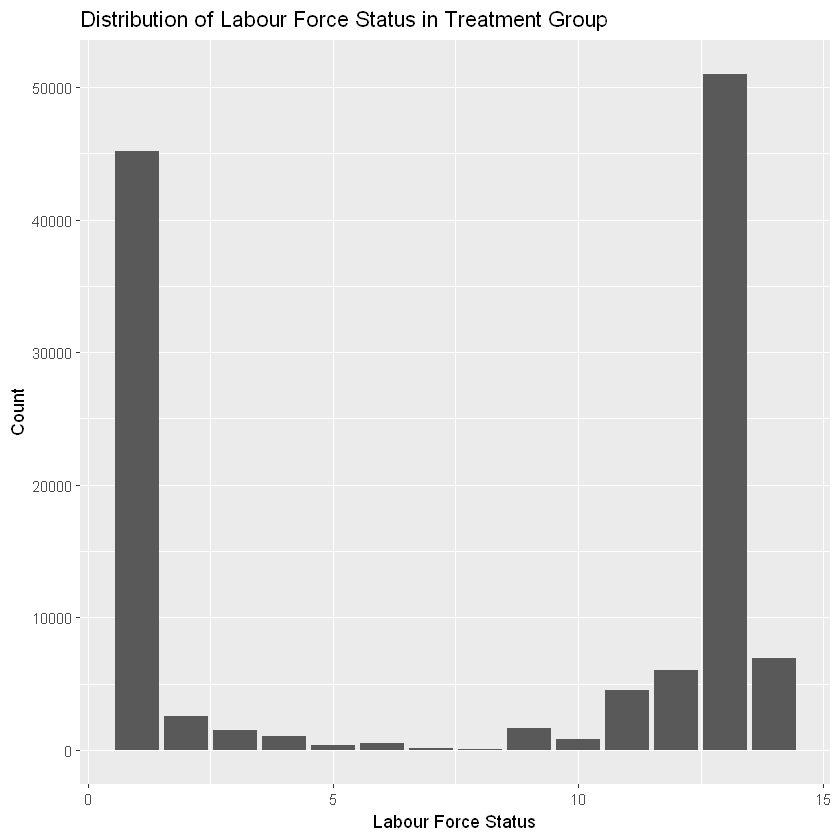

In [4]:
# Plot the distribution of labour outcome in the treatment group
ggplot(treatment_group, aes(x = lfact)) + 
    geom_bar() + 
    labs(x = "Labour Force Status", y = "Count") + 
    ggtitle("Distribution of Labour Force Status in Treatment Group")

In [5]:
control_group <- census_data|>
    filter(!Citizen %in% c(1, 2))|> # Select observations not available for OAS because of citizenship status
    filter(agegrp %in% c(16,17))|> # I use individuals at age 60-64 as pre and age 65-69 as post
    filter(!lfact %in% c(88, 99))  

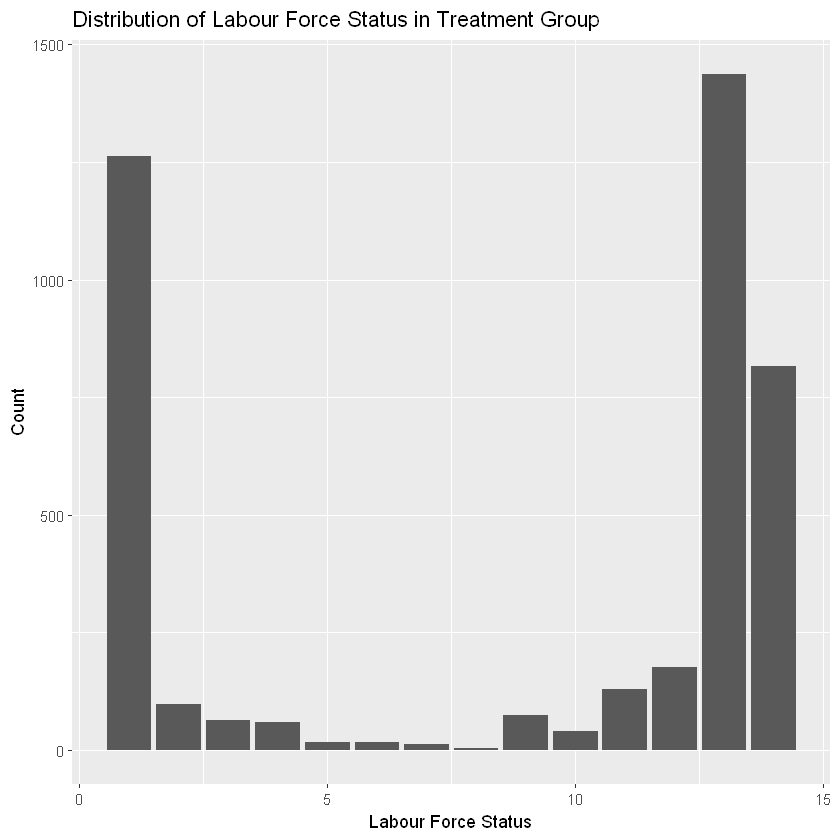

In [6]:
# Plot the distribution of labour status in the control group
ggplot(control_group, aes(x = lfact)) + 
    geom_bar() + 
    labs(x = "Labour Force Status", y = "Count") + 
    ggtitle("Distribution of Labour Force Status in Treatment Group")

In [7]:
# Combine the two datasets
treatment_group <- treatment_group |>
  mutate(group = 1)  # 1 for treatment

control_group <- control_group|>
  mutate(group = 0)  # 0 for control

combined_data <- bind_rows(treatment_group, control_group)

combined_data <- combined_data|>
  mutate(post = ifelse(agegrp == 17, 1, 0))|>
  mutate(employment = ifelse(lfact %in% c(1:9), 1, 0))|> # 1 represents employed, 0 represents unemployed
  filter(!hdgree %in% c(88, 99))|>
  select(employment, group, post, Gender, hdgree)|>
  glimpse()

Rows: 126,132
Columns: 5
$ employment <dbl> 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,…
$ group      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ post       <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,…
$ Gender     <dbl+lbl> 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1…
$ hdgree     <dbl+lbl>  5,  2,  9, 12,  6,  8,  9,  1,  2,  2,  2,  1,  2,  7,…


In [8]:
combined_data|>
    group_by(group, post)|>
    summarize(count = n())

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group,post,count
<dbl>,<dbl>,<int>
0,0,2257
0,1,1929
1,0,65714
1,1,56232


In [9]:
# We study the naive DD model without control
model0 <- lm(employment ~ post*group, data = combined_data)

summary(model0)


Call:
lm(formula = employment ~ post * group, data = combined_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5587 -0.2847 -0.2847  0.4413  0.7486 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.49180    0.01002  49.082  < 2e-16 ***
post        -0.24038    0.01476 -16.285  < 2e-16 ***
group        0.06692    0.01019   6.567 5.16e-11 ***
post:group  -0.03362    0.01501  -2.239   0.0251 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.476 on 126128 degrees of freedom
Multiple R-squared:  0.07584,	Adjusted R-squared:  0.07582 
F-statistic:  3450 on 3 and 126128 DF,  p-value: < 2.2e-16


In [10]:
# We study the model adding gender as a control
model1 <- lm(employment ~ Gender + post*group, data = combined_data)

summary(model1)


Call:
lm(formula = employment ~ Gender + post * group, data = combined_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6202 -0.3465 -0.2273  0.4990  0.8030 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.318939   0.010664  29.907  < 2e-16 ***
Gender       0.119204   0.002662  44.788  < 2e-16 ***
post        -0.241098   0.014645 -16.463  < 2e-16 ***
group        0.062822   0.010111   6.213 5.21e-10 ***
post:group  -0.032576   0.014894  -2.187   0.0287 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4723 on 126127 degrees of freedom
Multiple R-squared:  0.09031,	Adjusted R-squared:  0.09028 
F-statistic:  3130 on 4 and 126127 DF,  p-value: < 2.2e-16


In [11]:
# We study the model using highest degree as a control
model2 <- lm(employment ~ hdgree + post*group, data = combined_data)

summary(model2)


Call:
lm(formula = employment ~ hdgree + post * group, data = combined_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6712 -0.3843 -0.2495  0.4772  0.7934 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.4279395  0.0101456  42.180  < 2e-16 ***
hdgree       0.0134862  0.0003929  34.328  < 2e-16 ***
post        -0.2348143  0.0146930 -15.981  < 2e-16 ***
group        0.0679310  0.0101435   6.697 2.14e-11 ***
post:group  -0.0385635  0.0149428  -2.581  0.00986 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4738 on 126127 degrees of freedom
Multiple R-squared:  0.0844,	Adjusted R-squared:  0.08437 
F-statistic:  2907 on 4 and 126127 DF,  p-value: < 2.2e-16


In [12]:
# We incorporate both gender and highest degree as controls
model3 <- lm(employment ~ Gender + hdgree + post*group, data = combined_data)

summary(model3)


Call:
lm(formula = employment ~ Gender + hdgree + post * group, data = combined_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7314 -0.4048 -0.1926  0.4407  0.8471 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2564967  0.0107699  23.816  < 2e-16 ***
Gender       0.1186014  0.0026492  44.768  < 2e-16 ***
hdgree       0.0133706  0.0003898  34.302  < 2e-16 ***
post        -0.2355783  0.0145777 -16.160  < 2e-16 ***
group        0.0638444  0.0100643   6.344 2.25e-10 ***
post:group  -0.0374871  0.0148256  -2.529   0.0115 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4701 on 126126 degrees of freedom
Multiple R-squared:  0.09872,	Adjusted R-squared:  0.09868 
F-statistic:  2763 on 5 and 126126 DF,  p-value: < 2.2e-16


In [13]:
# Generate the regression summary table
summary_table <- stargazer(model0, model1, model2, model3, 
    type = "text", 
    title = "Effect of OAS Benefit on Employment",
    covariate.labels = c(
        "Gender (1 = Woman)",
        "Highest Degree",
        "Post 65 (1 = Yes)",
        "OAS (1 = Qualified)",
        "Post 65 x Group"),
    dep.var.labels = "Employment Status (1 = Employed)",
    digits = 3,
    omit.stat = "f",
    notes = "Data Source: Canadian Census 2021")


Effect of OAS Benefit on Employment
                                                  Dependent variable:                              
                    -------------------------------------------------------------------------------
                                           Employment Status (1 = Employed)                        
                            (1)                 (2)                 (3)                 (4)        
---------------------------------------------------------------------------------------------------
Gender (1 = Woman)                           0.119***                                0.119***      
                                              (0.003)                                 (0.003)      
                                                                                                   
Highest Degree                                                   0.013***            0.013***      
                                                               

In [14]:
summary_table <- stargazer(model0, model1, model2, model3, 
    type = "latex", 
    title = "Effect of OAS Benefit on Employment",
    covariate.labels = c(
        "Gender (1 = Woman)",
        "Highest Degree",
        "Post 65 (1 = Yes)",
        "OAS (1 = Qualified)",
        "Post 65 x Group"),
    dep.var.labels = "Employment Status (1 = Employed)",
    digits = 3,
    omit.stat = "f",
    notes = "Data Source: Canadian Census 2021")


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: 周三, 3月 26, 2025 - 14:30:07
\begin{table}[!htbp] \centering 
  \caption{Effect of OAS Benefit on Employment} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{4}{c}{Employment Status (1 = Employed)} \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 Gender (1 = Woman) &  & 0.119$^{***}$ &  & 0.119$^{***}$ \\ 
  &  & (0.003) &  & (0.003) \\ 
  & & & & \\ 
 Highest Degree &  &  & 0.013$^{***}$ & 0.013$^{***}$ \\ 
  &  &  & (0.0004) & (0.0004) \\ 
  & & & & \\ 
 Post 65 (1 = Yes) & $-$0.240$^{***}$ & $-$0.241$^{***}$ & $-$0.235$^{***}$ & $-$0.236$^{***}$ \\ 
  & (0.015) & (0.015) & (0.015) & (0.015) \\ 
  & & & & \\ 
 OAS (1 = Qualified) & 0.067$^{***}$ & 0.063$^{***}$ & 0.068$^{***}$ & 0.064$^{***}$ \\ 
  & (0.01